# Analisis Voice (Audio) menggunakan TSFEL dan MFCC

**Feature extraction audio (voice)** dengan [TSFEL] dan [MFCC] untuk klasifikasi suara "buka" dan "tutup"

## 0) Persiapan lingkungan (install & import)

In [ ]:
# pip install streamlit streamlit-webrtc audio-recorder-streamlit tsfel librosa soundfile numpy pandas matplotlib scikit-learn scipy pydub av joblib tqdm

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Audio utils
import soundfile as sf  # baca/tulis wav
import librosa          # pemrosesan audio
import librosa.display

# TSFEL
import tsfel

## 1) Muat semua file audio dari folder buka dan tutup

Loading 750 file dari folder 'buka'...
Loading 750 file dari folder 'tutup'...

Total audio loaded: 1500
Buka: 750, Tutup: 750
Sampling rate: 16000 Hz


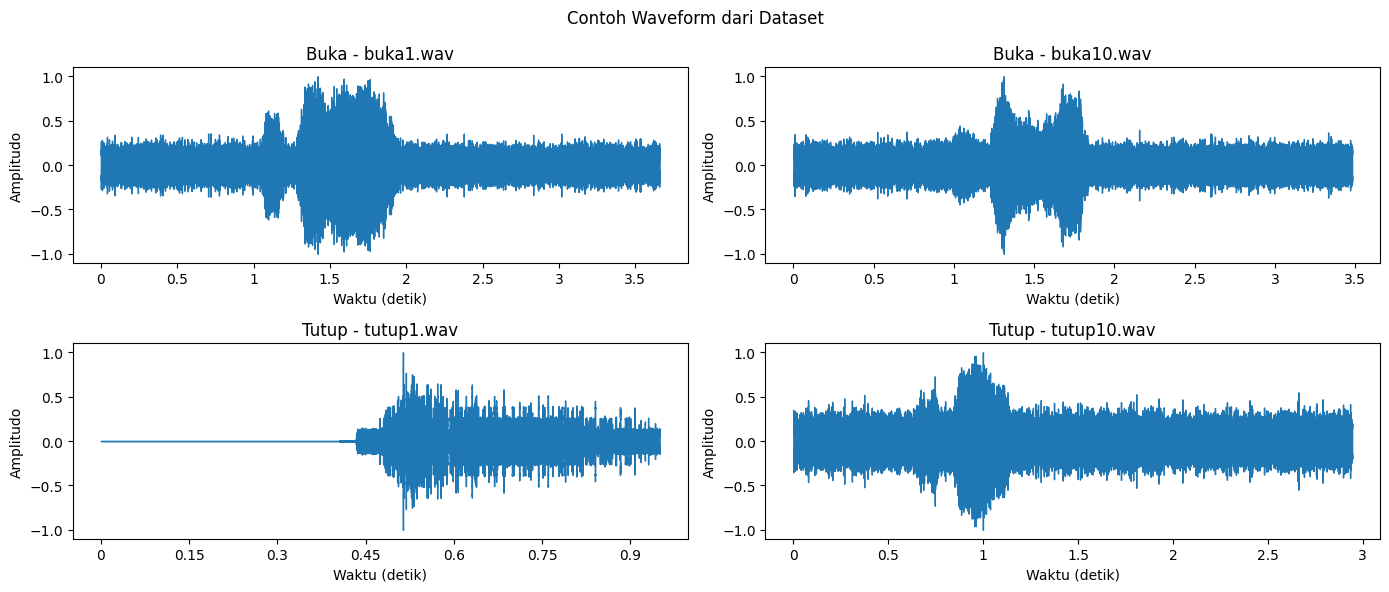

In [26]:
import os
from pathlib import Path

# Path ke folder dataset
BUKA_PATH = './voice_augmented//buka/'
TUTUP_PATH = './voice_augmented//tutup/'

# Parameter sampling
TARGET_SR = 16000  # 16 kHz umum untuk speech

# Fungsi untuk memuat dan preprocess audio
def load_audio_file(file_path, sr=16000):
    """Memuat file audio, trim silence, dan normalisasi"""
    y, sample_rate = librosa.load(file_path, sr=sr, mono=True)
    
    # Trim silence di awal/akhir
    y_trimmed, _ = librosa.effects.trim(y, top_db=25)
    
    # Normalisasi amplitudo
    if np.max(np.abs(y_trimmed)) > 0:
        y_trimmed = y_trimmed / np.max(np.abs(y_trimmed))
    
    return y_trimmed, sample_rate

# Kumpulkan semua file audio
audio_data = []
labels = []
filenames = []

# Load file dari folder buka
buka_files = sorted([f for f in os.listdir(BUKA_PATH) if f.endswith('.wav')])
print(f"Loading {len(buka_files)} file dari folder 'buka'...")
for file in buka_files:
    file_path = os.path.join(BUKA_PATH, file)
    y, sr = load_audio_file(file_path, TARGET_SR)
    audio_data.append(y)
    labels.append(0)  # Label 0 untuk "buka"
    filenames.append(file)

# Load file dari folder tutup
tutup_files = sorted([f for f in os.listdir(TUTUP_PATH) if f.endswith('.wav')])
print(f"Loading {len(tutup_files)} file dari folder 'tutup'...")
for file in tutup_files:
    file_path = os.path.join(TUTUP_PATH, file)
    y, sr = load_audio_file(file_path, TARGET_SR)
    audio_data.append(y)
    labels.append(1)  # Label 1 untuk "tutup"
    filenames.append(file)

print(f"\nTotal audio loaded: {len(audio_data)}")
print(f"Buka: {labels.count(0)}, Tutup: {labels.count(1)}")
print(f"Sampling rate: {TARGET_SR} Hz")

# Visualisasi beberapa contoh waveform
fig, axes = plt.subplots(2, 2, figsize=(14, 6))
fig.suptitle('Contoh Waveform dari Dataset')

# Plot 2 contoh dari "buka"
for i in range(2):
    librosa.display.waveshow(audio_data[i], sr=TARGET_SR, ax=axes[0, i])
    axes[0, i].set_title(f'Buka - {filenames[i]}')
    axes[0, i].set_xlabel('Waktu (detik)')
    axes[0, i].set_ylabel('Amplitudo')

# Plot 2 contoh dari "tutup"
buka_count = labels.count(0)
for i in range(2):
    librosa.display.waveshow(audio_data[buka_count + i], sr=TARGET_SR, ax=axes[1, i])
    axes[1, i].set_title(f'Tutup - {filenames[buka_count + i]}')
    axes[1, i].set_xlabel('Waktu (detik)')
    axes[1, i].set_ylabel('Amplitudo')

plt.tight_layout()
plt.show()

## 2) Analisis durasi audio dan statistik dasar

Statistik Durasi Audio (detik):
Buka  - Mean: 1.557, Std: 1.141, Min: 0.320, Max: 4.608
Tutup - Mean: 1.577, Std: 1.338, Min: 0.192, Max: 4.969


/tmp/ipykernel_18842/3851146594.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([durations_buka, durations_tutup], labels=['Buka', 'Tutup'])


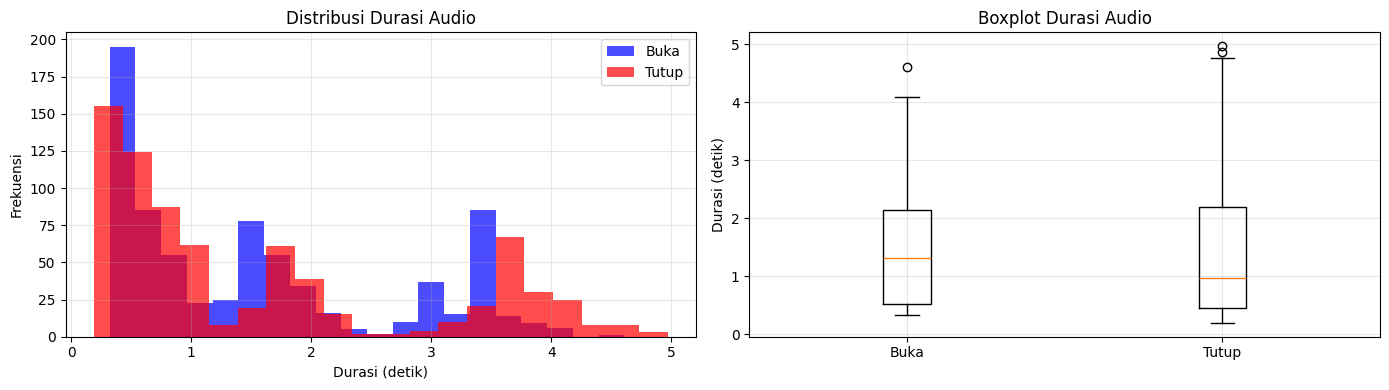

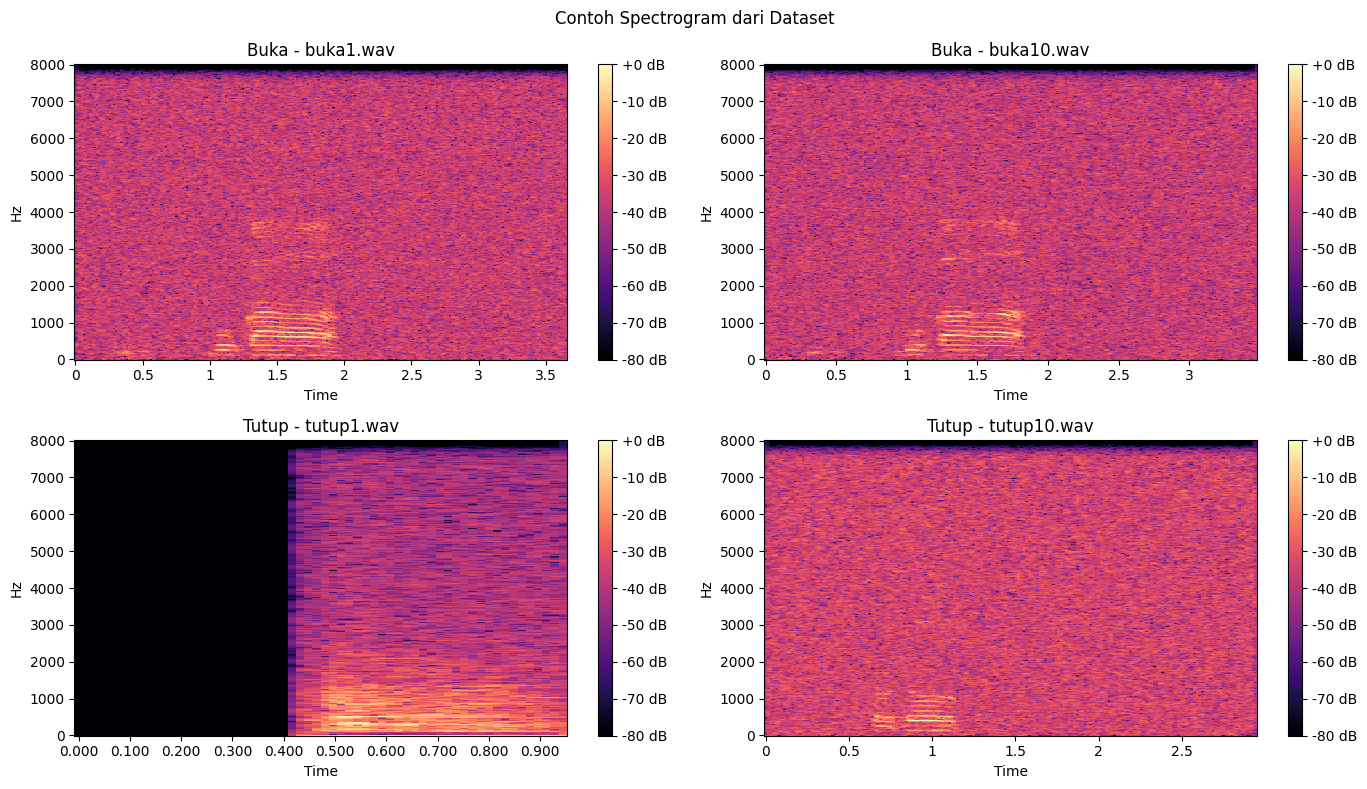

In [27]:
# Analisis durasi audio
durations = [len(y) / TARGET_SR for y in audio_data]
durations_buka = [d for d, l in zip(durations, labels) if l == 0]
durations_tutup = [d for d, l in zip(durations, labels) if l == 1]

# Statistik durasi
print("Statistik Durasi Audio (detik):")
print(f"Buka  - Mean: {np.mean(durations_buka):.3f}, Std: {np.std(durations_buka):.3f}, Min: {np.min(durations_buka):.3f}, Max: {np.max(durations_buka):.3f}")
print(f"Tutup - Mean: {np.mean(durations_tutup):.3f}, Std: {np.std(durations_tutup):.3f}, Min: {np.min(durations_tutup):.3f}, Max: {np.max(durations_tutup):.3f}")

# Visualisasi distribusi durasi
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].hist(durations_buka, bins=20, alpha=0.7, label='Buka', color='blue')
axes[0].hist(durations_tutup, bins=20, alpha=0.7, label='Tutup', color='red')
axes[0].set_xlabel('Durasi (detik)')
axes[0].set_ylabel('Frekuensi')
axes[0].set_title('Distribusi Durasi Audio')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Boxplot durasi
axes[1].boxplot([durations_buka, durations_tutup], labels=['Buka', 'Tutup'])
axes[1].set_ylabel('Durasi (detik)')
axes[1].set_title('Boxplot Durasi Audio')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Visualisasi spectrogram untuk beberapa contoh
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fig.suptitle('Contoh Spectrogram dari Dataset')

# Spectrogram 2 contoh dari "buka"
for i in range(2):
    S = librosa.amplitude_to_db(np.abs(librosa.stft(audio_data[i], n_fft=1024, hop_length=256)), ref=np.max)
    img = librosa.display.specshow(S, sr=TARGET_SR, hop_length=256, x_axis='time', y_axis='linear', ax=axes[0, i])
    axes[0, i].set_title(f'Buka - {filenames[i]}')
    fig.colorbar(img, ax=axes[0, i], format='%+2.0f dB')

# Spectrogram 2 contoh dari "tutup"
buka_count = labels.count(0)
for i in range(2):
    S = librosa.amplitude_to_db(np.abs(librosa.stft(audio_data[buka_count + i], n_fft=1024, hop_length=256)), ref=np.max)
    img = librosa.display.specshow(S, sr=TARGET_SR, hop_length=256, x_axis='time', y_axis='linear', ax=axes[1, i])
    axes[1, i].set_title(f'Tutup - {filenames[buka_count + i]}')
    fig.colorbar(img, ax=axes[1, i], format='%+2.0f dB')

plt.tight_layout()
plt.show()

## 3) Konfigurasi fitur TSFEL

In [28]:
import tsfel
import librosa
import numpy as np
import pandas as pd

# Ambil set fitur lintas domain
# Kamu bisa ubah domain sesuai kebutuhan
cfg = tsfel.get_features_by_domain(["statistical"])  
n_feats = tsfel.get_number_features(cfg)
print('Jumlah fitur TSFEL yang akan diekstrak:', n_feats)

Jumlah fitur TSFEL yang akan diekstrak: 31


## 4) Ekstraksi fitur TSFEL untuk semua audio

Kita akan mengekstrak fitur untuk setiap file audio menggunakan TSFEL.
Strategi: Ekstrak fitur dari **seluruh sinyal** (full-signal) untuk setiap file audio, sehingga setiap file akan menghasilkan satu vektor fitur.

In [29]:
def extract_mfcc_features(y, sr, n_mfcc=13):
    """
    Ekstrak fitur MFCC dan statistiknya (mean, std, delta)
    """
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std = np.std(mfcc, axis=1)
    
    # Tambahkan delta (perubahan antar frame)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta_mean = np.mean(mfcc_delta, axis=1)
    
    # Gabungkan semua ke 1 vektor fitur
    features = np.hstack([mfcc_mean, mfcc_std, mfcc_delta_mean])
    feature_names = (
        [f"mfcc_mean_{i+1}" for i in range(n_mfcc)] +
        [f"mfcc_std_{i+1}" for i in range(n_mfcc)] +
        [f"mfcc_delta_mean_{i+1}" for i in range(n_mfcc)]
    )
    return features, feature_names


# Ekstraksi fitur gabungan TSFEL + MFCC
print("Mengekstrak fitur TSFEL + MFCC untuk setiap file audio...")

features_list = []
for i, (y, label) in enumerate(zip(audio_data, labels)):
    try:
        # --- TSFEL features ---
        X_tsfel = tsfel.time_series_features_extractor(cfg, y, fs=TARGET_SR, verbose=0)
        tsfel_feats = X_tsfel.iloc[0].values

        # --- MFCC features ---
        mfcc_feats, mfcc_names = extract_mfcc_features(y, TARGET_SR)

        # Gabungkan fitur
        all_features = np.concatenate([tsfel_feats, mfcc_feats])
        features_list.append(all_features)

        if (i + 1) % 20 == 0:
            print(f"Progress: {i + 1}/{len(audio_data)} file selesai...")

    except Exception as e:
        print(f"Error pada file {filenames[i]}: {str(e)}")
        features_list.append(np.full(n_feats + len(mfcc_names), np.nan))

print(f"Ekstraksi fitur selesai untuk {len(features_list)} file audio.")

# Buat DataFrame dengan nama fitur
feature_names_tsfel = list(X_tsfel.columns)
feature_names_all = feature_names_tsfel + mfcc_names

X_all = pd.DataFrame(features_list, columns=feature_names_all)
X_all['label'] = labels
X_all['filename'] = filenames

print(f"\nShape fitur gabungan: {X_all.shape}")
print(f"Fitur total: {X_all.shape[1] - 2} features + label + filename")
X_all.head()

Mengekstrak fitur TSFEL + MFCC untuk setiap file audio...


Progress: 20/1500 file selesai...
Progress: 40/1500 file selesai...
Progress: 60/1500 file selesai...
Progress: 80/1500 file selesai...
Progress: 100/1500 file selesai...
Progress: 120/1500 file selesai...
Progress: 140/1500 file selesai...
Progress: 160/1500 file selesai...
Progress: 180/1500 file selesai...
Progress: 200/1500 file selesai...
Progress: 220/1500 file selesai...
Progress: 240/1500 file selesai...
Progress: 260/1500 file selesai...
Progress: 280/1500 file selesai...
Progress: 300/1500 file selesai...
Progress: 320/1500 file selesai...
Progress: 340/1500 file selesai...
Progress: 360/1500 file selesai...
Progress: 380/1500 file selesai...
Progress: 400/1500 file selesai...
Progress: 420/1500 file selesai...
Progress: 440/1500 file selesai...
Progress: 460/1500 file selesai...
Progress: 480/1500 file selesai...
Progress: 500/1500 file selesai...
Progress: 520/1500 file selesai...
Progress: 540/1500 file selesai...
Progress: 560/1500 file selesai...
Progress: 580/1500 file 

,0_Absolute energy,0_Average power,0_ECDF Percentile Count_0,0_ECDF Percentile Count_1,0_ECDF Percentile_0,0_ECDF Percentile_1,0_ECDF_0,0_ECDF_1,0_ECDF_2,0_ECDF_3,...,mfcc_delta_mean_6,mfcc_delta_mean_7,mfcc_delta_mean_8,mfcc_delta_mean_9,mfcc_delta_mean_10,mfcc_delta_mean_11,mfcc_delta_mean_12,mfcc_delta_mean_13,label,filename
0,1319.048673,360.457366,11710.0,46840.0,-0.088791,0.088680,0.000017,0.000034,0.000051,0.000068,...,0.086178,-0.017085,-0.007622,0.010308,0.010714,0.003151,-0.004558,-0.016517,0,buka1.wav
1,962.791761,276.669268,11136.0,44544.0,-0.087463,0.090739,0.000018,0.000036,0.000054,0.000072,...,0.033380,0.061912,-0.024128,-0.046122,-0.003653,-0.029177,-0.000485,-0.028861,0,buka10.wav
2,227.175083,546.176008,1331.0,5324.0,-0.096591,0.085642,0.000150,0.000300,0.000451,0.000601,...,-0.282191,-1.217166,3.169637,3.725600,3.224836,-0.323296,-0.395047,-2.315844,0,buka100.wav
3,794.775149,228.387765,11136.0,44544.0,-0.057473,0.054334,0.000018,0.000036,0.000054,0.000072,...,-0.041964,-0.025339,-0.036359,-0.007578,0.036340,-0.057423,-0.045830,-0.047804,0,buka101.wav
4,1278.495318,1014.175760,4034.0,16136.0,-0.184395,0.174888,0.000050,0.000099,0.000149,0.000198,...,0.574980,0.498110,0.262112,0.312859,0.581482,0.607217,0.417455,-0.175403,0,buka102.wav


## 5) Bersihkan fitur (NaN/Inf), simpan ke CSV

In [30]:
import numpy as np
import pandas as pd

# Salin data awal (gabungan TSFEL + MFCC)
X_clean = X_all.copy()

# Ganti nilai inf/-inf menjadi NaN
X_clean = X_clean.replace([np.inf, -np.inf], np.nan)

# Pisahkan label & filename sebelum proses cleaning fitur
y_labels = X_clean['label'].values
file_names = X_clean['filename'].values

# Ambil hanya fitur numerik
X_features = X_clean.drop(columns=['label', 'filename'])

# --- Tahap 1: Hapus kolom yang seluruhnya NaN ---
drop_all_nan = [c for c in X_features.columns if X_features[c].isna().all()]
X_features = X_features.drop(columns=drop_all_nan)

# --- Tahap 2: Hapus kolom yang sebagian ada NaN ---
# (Jika kamu mau imputasi pakai median, bisa ganti bagian ini)
drop_any_nan = [c for c in X_features.columns if X_features[c].isna().any()]
X_features = X_features.drop(columns=drop_any_nan)

# --- Tahap 3 (opsional): Drop kolom yang variansinya 0 ---
# Agar tidak ada fitur konstan yang tidak berguna
zero_var_cols = [c for c in X_features.columns if X_features[c].nunique() <= 1]
X_features = X_features.drop(columns=zero_var_cols)

# Tampilkan info hasil cleaning
print(f'Hapus kolom all-NaN     : {len(drop_all_nan)} kolom')
print(f'Hapus kolom dengan NaN  : {len(drop_any_nan)} kolom')
print(f'Hapus kolom variansi 0  : {len(zero_var_cols)} kolom')
print(f'Shape setelah clean     : {X_features.shape}')

# Gabungkan kembali dengan label & filename
X_clean = X_features.copy()
X_clean['label'] = y_labels
X_clean['filename'] = file_names

# --- Cek distribusi label ---
print('\nDistribusi label:')
print(X_clean['label'].value_counts())

X_clean.head()


Hapus kolom all-NaN     : 0 kolom
Hapus kolom dengan NaN  : 70 kolom
Hapus kolom variansi 0  : 0 kolom
Shape setelah clean     : (1500, 0)

Distribusi label:
label
0    750
1    750
Name: count, dtype: int64


,label,filename
0,0,buka1.wav
1,0,buka10.wav
2,0,buka100.wav
3,0,buka101.wav
4,0,buka102.wav


## 6) Standarisasi & visualisasi (PCA 2D)

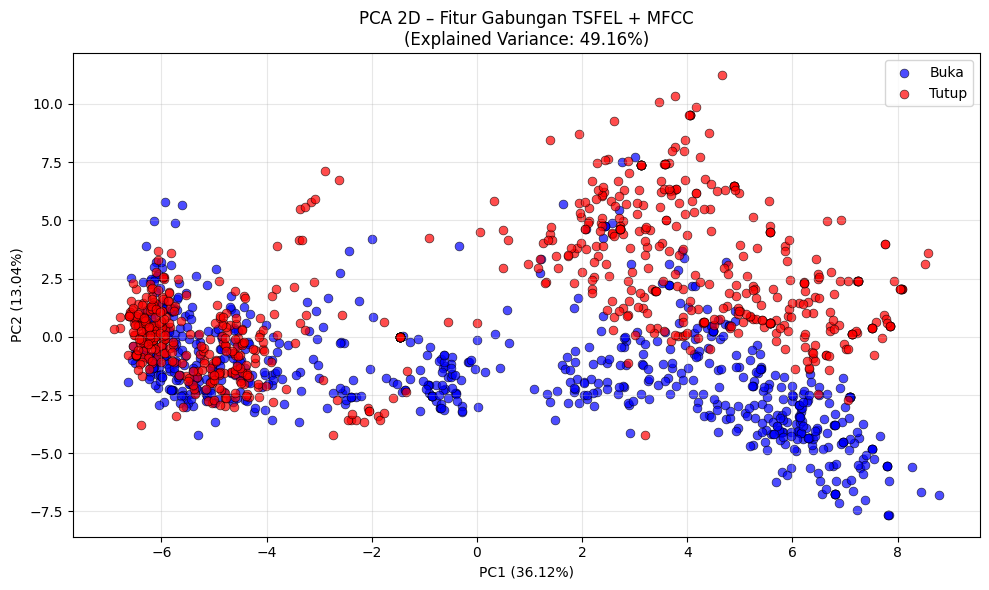


Fitur gabungan tersimpan ke: voice_features_tsfel_mfcc.csv
Total sampel: 1500, Total fitur: 70


In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import numpy as np

# Pastikan DataFrame berasal dari hasil gabungan TSFEL + MFCC
X_clean = X_all.dropna(subset=['label']).reset_index(drop=True)

# Pisahkan fitur dan label
X_for_scaling = X_clean.drop(columns=['label', 'filename']).values
y_for_viz = X_clean['label'].values

# --- 🔧 Imputasi nilai NaN ---
imputer = SimpleImputer(strategy='median')  # bisa juga 'mean'
X_imputed = imputer.fit_transform(X_for_scaling)

# --- Standarisasi fitur ---
scaler = StandardScaler()
Z = scaler.fit_transform(X_imputed)

# --- PCA ke 2 dimensi ---
pca = PCA(n_components=2, random_state=42)
Z2 = pca.fit_transform(Z)

# --- Visualisasi PCA ---
plt.figure(figsize=(10, 6))
colors = ['blue', 'red']
labels_name = ['Buka', 'Tutup']

for i, name in enumerate(labels_name):
    mask = (y_for_viz == i) if np.issubdtype(y_for_viz.dtype, np.number) else (y_for_viz == name)
    plt.scatter(Z2[mask, 0], Z2[mask, 1],
                s=40, alpha=0.7, c=colors[i],
                label=name, edgecolors='k', linewidth=0.5)

plt.title(f'PCA 2D – Fitur Gabungan TSFEL + MFCC\n(Explained Variance: {pca.explained_variance_ratio_.sum():.2%})')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- Simpan hasil ke CSV ---
out_csv = 'voice_features_tsfel_mfcc.csv'
X_clean.to_csv(out_csv, index=False)
print(f'\nFitur gabungan tersimpan ke: {out_csv}')
print(f'Total sampel: {len(X_clean)}, Total fitur: {X_clean.shape[1] - 2}')


## 7) Klasifikasi dengan berbagai algoritma

Kita akan menguji beberapa model klasifikasi untuk membedakan suara "buka" dan "tutup".

In [32]:
import os
import json
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# ==========================================================
# 🔹 Konfigurasi Umum
# ==========================================================
TARGET_SR = 16000  # sample rate audio target (wajib disimpan agar app tahu)
FEATURE_FILE = "voice_features_tsfel_mfcc.csv"
ARTIFACT_DIR = "artifacts"

# ==========================================================
# 🔹 Load dataset hasil ekstraksi fitur (TSFEL + MFCC)
# ==========================================================
print("Loading feature dataset...")

df = pd.read_csv(FEATURE_FILE)

# Pastikan kolom 'label' dan 'filename' ada
assert "label" in df.columns, "Kolom 'label' tidak ditemukan!"
assert "filename" in df.columns, "Kolom 'filename' tidak ditemukan!"

# Pisahkan fitur dan label
X = df.drop(columns=["label", "filename"])
y = df["label"]

print(f"Dataset loaded: {X.shape}")
print(f"Total features digunakan untuk training: {X.shape[1]}")
print(f"   Contoh fitur: {list(X.columns[:5])}")

# ==========================================================
# 🔹 Split data train dan test
# ==========================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"\nData split -> Train: {X_train.shape}, Test: {X_test.shape}")

# ==========================================================
# 🔹 Scaling fitur
# ==========================================================
print("\nScaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("✓ Feature scaling completed.")

# ==========================================================
# 🔹 Training RandomForestClassifier
# ==========================================================
print("\nTraining RandomForestClassifier...")
model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1,
)
model.fit(X_train_scaled, y_train)

# ==========================================================
# 🔹 Evaluasi model
# ==========================================================
train_pred = model.predict(X_train_scaled)
test_pred = model.predict(X_test_scaled)

train_score = accuracy_score(y_train, train_pred)
test_score = accuracy_score(y_test, test_pred)

print(f"\nflush=Training accuracy : {train_score:.4f}")
print(f"Test accuracy     : {test_score:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, test_pred))

# ==========================================================
# 🔹 Simpan artifacts
# ==========================================================
print("\nSaving model artifacts...")

os.makedirs(ARTIFACT_DIR, exist_ok=True)

# Simpan model & scaler
joblib.dump(model, f"{ARTIFACT_DIR}/voice_classifier_model.pkl")
print(f"✓ Model saved: {ARTIFACT_DIR}/voice_classifier_model.pkl")

joblib.dump(scaler, f"{ARTIFACT_DIR}/voice_scaler.pkl")
print(f"✓ Scaler saved: {ARTIFACT_DIR}/voice_scaler.pkl")

# Simpan nama fitur
feature_names = list(X.columns)
joblib.dump(feature_names, f"{ARTIFACT_DIR}/feature_names.pkl")
print(f"✓ Feature names saved: {ARTIFACT_DIR}/feature_names.pkl ({len(feature_names)} features)")

# Jika kamu punya konfigurasi TSFEL (cfg), tambahkan di sini:
if os.path.exists("tsfel_config.pkl"):
    joblib.dump(joblib.load("tsfel_config.pkl"), f"{ARTIFACT_DIR}/tsfel_config.pkl")
    print(f"✓ TSFEL config copied: {ARTIFACT_DIR}/tsfel_config.pkl")

# ==========================================================
# 🔹 Simpan metadata model
# ==========================================================
metadata = {
    "target_sr": TARGET_SR,                  
    "n_features": len(feature_names),
    "train_accuracy": float(train_score),
    "test_accuracy": float(test_score),
    "label_map": {0: "Buka", 1: "Tutup"},
    "feature_source": ["TSFEL", "MFCC"],
}

joblib.dump(metadata, f"{ARTIFACT_DIR}/model_metadata.pkl")
with open(f"{ARTIFACT_DIR}/model_metadata.json", "w") as f:
    json.dump(metadata, f, indent=4)

print("✓ Metadata saved: model_metadata.pkl & model_metadata.json")

print("\n" + "=" * 60)
print("All artifacts saved successfully in folder 'artifacts/'")
print("=" * 60)


Loading feature dataset...
Dataset loaded: (1500, 70)
Total features digunakan untuk training: 70
   Contoh fitur: ['0_Absolute energy', '0_Average power', '0_ECDF Percentile Count_0', '0_ECDF Percentile Count_1', '0_ECDF Percentile_0']

Data split -> Train: (1200, 70), Test: (300, 70)

Scaling features...
✓ Feature scaling completed.

Training RandomForestClassifier...



flush=Training accuracy : 1.0000
Test accuracy     : 0.9967

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       150
           1       1.00      0.99      1.00       150

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300


Saving model artifacts...
✓ Model saved: artifacts/voice_classifier_model.pkl
✓ Scaler saved: artifacts/voice_scaler.pkl
✓ Feature names saved: artifacts/feature_names.pkl (70 features)
✓ Metadata saved: model_metadata.pkl & model_metadata.json

All artifacts saved successfully in folder 'artifacts/'


In [36]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import librosa
import librosa.display
import tsfel
import joblib
import soundfile as sf
import tempfile
import os
from io import BytesIO
import matplotlib.pyplot as plt
from audio_recorder_streamlit import audio_recorder

# ==========================================================
# Konfigurasi halaman
# ==========================================================
st.set_page_config(
    page_title="Klasifikasi Suara Buka/Tutup",
    page_icon="🎙️",
    layout="wide"
)

# ==========================================================
# Load model dan artefak
# ==========================================================
@st.cache_resource
def load_model_artifacts():
    model = joblib.load('artifacts/voice_classifier_model.pkl')
    scaler = joblib.load('artifacts/voice_scaler.pkl')
    feature_names = joblib.load('artifacts/feature_names.pkl')
    metadata = joblib.load('artifacts/model_metadata.pkl')
    cfg = tsfel.get_features_by_domain(["statistical"])
    return model, scaler, feature_names, metadata, cfg

# ==========================================================
# Preprocessing audio
# ==========================================================
def preprocess_audio(y, sr, target_sr=16000):
    """Resample, trim, dan normalisasi audio"""
    if y is None or len(y) == 0:
        raise ValueError("File audio kosong atau tidak terbaca.")

    # Resample jika perlu
    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
        sr = target_sr

    # Trim (hapus bagian diam)
    y_trimmed, _ = librosa.effects.trim(y, top_db=25)

    # Normalisasi amplitudo
    if len(y_trimmed) > 0 and np.max(np.abs(y_trimmed)) > 0:
        y_trimmed = y_trimmed / np.max(np.abs(y_trimmed))

    if len(y_trimmed) < sr * 0.1:
        raise ValueError("Audio terlalu pendek setelah trimming.")

    return y_trimmed, sr

# ==========================================================
# Ekstraksi fitur gabungan (TSFEL + MFCC)
# ==========================================================
def extract_combined_features(y, sr, feature_names, cfg):
    """Ekstraksi fitur gabungan TSFEL + MFCC"""
    try:
        if y is None or len(y) < 2048:
            raise ValueError(f"Audio terlalu pendek (len={len(y)})")

        # --- TSFEL (statistical domain) ---
        X_tsfel = tsfel.time_series_features_extractor(cfg, y, fs=sr, verbose=0)
        if X_tsfel.shape[0] == 0:
            raise ValueError("Hasil ekstraksi TSFEL kosong.")
        tsfel_feats = X_tsfel.iloc[0].values

        # --- MFCC ringkas ---
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_std = np.std(mfcc, axis=1)
        mfcc_feats = np.concatenate([mfcc_mean, mfcc_std])

        # --- Gabungkan ---
        all_features = np.concatenate([tsfel_feats, mfcc_feats])

        # Samakan panjang
        if len(all_features) != len(feature_names):
            diff = len(feature_names) - len(all_features)
            if diff > 0:
                all_features = np.append(all_features, np.zeros(diff))
            else:
                all_features = all_features[:len(feature_names)]

        return all_features.reshape(1, -1)

    except Exception as e:
        st.error(f"Error ekstraksi fitur: {e}")
        return None

# ==========================================================
# Prediksi
# ==========================================================
def predict_audio(y, sr, model, scaler, feature_names, metadata, cfg):
    try:
        y_proc, sr_proc = preprocess_audio(y, sr, metadata["target_sr"])

        if len(y_proc) < 2048:
            st.error("Audio terlalu pendek setelah preprocessing.")
            return None, None, None

        features = extract_combined_features(y_proc, sr_proc, feature_names, cfg)
        if features is None:
            return None, None, None

        if np.isnan(features).any():
            features = np.nan_to_num(features)

        features_df = pd.DataFrame(features, columns=feature_names)
        features_scaled = scaler.transform(features_df)
        prediction = model.predict(features_scaled)[0]
        probabilities = model.predict_proba(features_scaled)[0]

        return prediction, probabilities, y_proc
    except Exception as e:
        st.error(f"Error prediksi: {e}")
        return None, None, None

# ==========================================================
# Visualisasi audio
# ==========================================================
def plot_waveform_and_spectrogram(y, sr):
    fig, axes = plt.subplots(2, 1, figsize=(10, 6))
    librosa.display.waveshow(y, sr=sr, ax=axes[0], color='royalblue')
    axes[0].set_title("Waveform")
    axes[0].set_xlabel("Waktu (detik)")
    axes[0].set_ylabel("Amplitudo")
    axes[0].grid(alpha=0.3)

    S = librosa.amplitude_to_db(np.abs(librosa.stft(y, n_fft=1024, hop_length=256)), ref=np.max)
    img = librosa.display.specshow(S, sr=sr, hop_length=256, x_axis='time', y_axis='linear', ax=axes[1], cmap='magma')
    axes[1].set_title("Spectrogram (dB)")
    fig.colorbar(img, ax=axes[1], format='%+2.0f dB')
    plt.tight_layout()
    return fig

# ==========================================================
# Main App
# ==========================================================
def main():
    st.title("Klasifikasi Suara Buka/Tutup")
    st.markdown("""
    Aplikasi ini mengklasifikasikan suara menjadi **Buka** atau **Tutup** 
    menggunakan model Machine Learning berbasis **TSFEL + MFCC + Random Forest**.
    """)

    with st.spinner("Memuat model..."):
        model, scaler, feature_names, metadata, cfg = load_model_artifacts()

    # Sidebar informasi
    st.sidebar.header("Informasi Model")
    st.sidebar.write(f"**Akurasi Training:** {metadata['train_accuracy']:.2%}")
    st.sidebar.write(f"**Akurasi Testing:** {metadata['test_accuracy']:.2%}")
    st.sidebar.write(f"**Jumlah Fitur:** {metadata['n_features']}")
    st.sidebar.write(f"**Sample Rate:** {metadata['target_sr']} Hz")
    st.sidebar.markdown("---")
    st.sidebar.header("Petunjuk")
    st.sidebar.markdown("""
    1. Rekam atau upload suara (.wav / .mp3)  
    2. Klik **Prediksi**  
    3. Lihat hasil dan visualisasi  
    """)

    st.subheader("Rekam atau Upload Suara")

    option = st.radio("Pilih sumber audio:", ["Rekam Langsung", "Upload File"])
    audio_data, sr = None, None

    if option == "Rekam Langsung":
        audio_bytes = audio_recorder(
            text="Klik untuk mulai/stop rekam",
            recording_color="#e74c3c",
            neutral_color="#3498db",
            icon_size="2x"
        )
        if audio_bytes:
            with tempfile.NamedTemporaryFile(delete=False, suffix=".wav") as tmp:
                tmp.write(audio_bytes)
                tmp_path = tmp.name
            try:
                y, sr = librosa.load(tmp_path, sr=None, mono=True)
                st.audio(audio_bytes, format="audio/wav")
                audio_data = y
            finally:
                os.remove(tmp_path)

    else:
        uploaded_file = st.file_uploader("Upload file audio", type=["wav", "mp3"])
        if uploaded_file is not None:
            with tempfile.NamedTemporaryFile(delete=False, suffix=".wav") as tmp:
                tmp.write(uploaded_file.read())
                tmp_path = tmp.name
            try:
                y, sr = librosa.load(tmp_path, sr=None, mono=True)
                st.audio(uploaded_file, format="audio/wav")
                audio_data = y
            finally:
                os.remove(tmp_path)

    # ==========================================
    # Tombol Prediksi
    # ==========================================
    if audio_data is not None and sr is not None:
        durasi = len(audio_data) / sr
        st.info(f"Durasi audio: **{durasi:.2f} detik**  |  Sample rate: **{sr} Hz**")

        if len(audio_data) < 2048:
            st.error("Audio terlalu pendek. Mohon rekam ulang minimal 0.5 detik.")
        elif st.button("Prediksi"):
            with st.spinner("Memproses dan memprediksi..."):
                pred, prob, y_proc = predict_audio(audio_data, sr, model, scaler, feature_names, metadata, cfg)
                if pred is not None:
                    label = metadata["label_map"][pred]
                    confidence = prob[pred] * 100
                    st.success(f"**Prediksi:** {label} ({confidence:.2f}%)")

                    st.markdown("#### Probabilitas:")
                    for i, name in metadata["label_map"].items():
                        st.write(f"{name}: {prob[i]*100:.2f}%")
                        st.progress(prob[i])

                    fig = plot_waveform_and_spectrogram(y_proc, metadata["target_sr"])
                    st.pyplot(fig)

if __name__ == "__main__":
    main()


Overwriting app.py


In [34]:
# %%writefile app.py
# import streamlit as st
# import pandas as pd
# import numpy as np
# import librosa
# import librosa.display
# import tsfel
# import joblib
# import soundfile as sf
# import tempfile
# import os
# from io import BytesIO
# import matplotlib.pyplot as plt

# # ==========================================================
# # 🎛️ Konfigurasi halaman
# # ==========================================================
# st.set_page_config(
#     page_title="Klasifikasi Suara Buka/Tutup",
#     page_icon="🎙️",
#     layout="wide"
# )

# # ==========================================================
# # 📦 Load model dan artefak
# # ==========================================================
# @st.cache_resource
# def load_model_artifacts():
#     model = joblib.load('artifacts/voice_classifier_model.pkl')
#     scaler = joblib.load('artifacts/voice_scaler.pkl')
#     feature_names = joblib.load('artifacts/feature_names.pkl')
#     metadata = joblib.load('artifacts/model_metadata.pkl')
#     return model, scaler, feature_names, metadata


# # ==========================================================
# # 🎚️ Preprocessing audio
# # ==========================================================
# def preprocess_audio(y, sr, target_sr=16000):
#     """Resample, trim, dan normalisasi audio"""
#     if sr != target_sr:
#         y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
#         sr = target_sr
#     y_trimmed, _ = librosa.effects.trim(y, top_db=25)
#     if np.max(np.abs(y_trimmed)) > 0:
#         y_trimmed = y_trimmed / np.max(np.abs(y_trimmed))
#     return y_trimmed, sr


# # ==========================================================
# # 🔍 Ekstraksi fitur (TSFEL + MFCC)
# # ==========================================================
# def extract_mfcc_features(y, sr, n_mfcc=13):
#     """Ekstrak fitur MFCC: mean, std, delta mean"""
#     mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
#     mfcc_mean = np.mean(mfcc, axis=1)
#     mfcc_std = np.std(mfcc, axis=1)
#     mfcc_delta = librosa.feature.delta(mfcc)
#     mfcc_delta_mean = np.mean(mfcc_delta, axis=1)
#     return np.hstack([mfcc_mean, mfcc_std, mfcc_delta_mean])


# def extract_combined_features(y, sr, feature_names):
#     """Ekstraksi fitur gabungan TSFEL + MFCC"""
#     try:
#         # TSFEL hanya untuk domain statistical
#         cfg = tsfel.get_features_by_domain(["statistical"])
#         X_tsfel = tsfel.time_series_features_extractor(cfg, y, fs=sr, verbose=0)
#         tsfel_feats = X_tsfel.iloc[0].values

#         mfcc_feats = extract_mfcc_features(y, sr)

#         all_features = np.concatenate([tsfel_feats, mfcc_feats])

#         # Sesuaikan panjangnya agar sama dengan feature_names
#         if len(all_features) != len(feature_names):
#             diff = len(feature_names) - len(all_features)
#             if diff > 0:
#                 all_features = np.append(all_features, np.zeros(diff))
#             else:
#                 all_features = all_features[:len(feature_names)]

#         return all_features.reshape(1, -1)

#     except Exception as e:
#         st.error(f"⚠️ Error saat ekstraksi fitur: {str(e)}")
#         return None


# # ==========================================================
# # 🧠 Prediksi
# # ==========================================================
# def predict_audio(y, sr, model, scaler, feature_names, metadata):
#     """Prediksi kelas audio"""
#     y_proc, sr_proc = preprocess_audio(y, sr, metadata["target_sr"])
#     features = extract_combined_features(y_proc, sr_proc, feature_names)
#     if features is None:
#         return None, None, None

#     # Tangani NaN
#     if np.isnan(features).any():
#         st.warning("Beberapa fitur mengandung NaN. Nilai diganti dengan 0.")
#         features = np.nan_to_num(features)

#     # ✅ Bungkus fitur jadi DataFrame agar nama kolom sesuai dengan scaler
#     features_df = pd.DataFrame(features, columns=feature_names)

#     # Scaling dan prediksi
#     features_scaled = scaler.transform(features_df)
#     prediction = model.predict(features_scaled)[0]
#     probabilities = model.predict_proba(features_scaled)[0]

#     return prediction, probabilities, y_proc



# # ==========================================================
# # 🎧 Visualisasi audio
# # ==========================================================
# def plot_waveform_and_spectrogram(y, sr):
#     fig, axes = plt.subplots(2, 1, figsize=(10, 6))
#     librosa.display.waveshow(y, sr=sr, ax=axes[0], color='royalblue')
#     axes[0].set_title("Waveform")
#     axes[0].set_xlabel("Waktu (detik)")
#     axes[0].set_ylabel("Amplitudo")
#     axes[0].grid(alpha=0.3)

#     S = librosa.amplitude_to_db(np.abs(librosa.stft(y, n_fft=1024, hop_length=256)), ref=np.max)
#     img = librosa.display.specshow(S, sr=sr, hop_length=256, x_axis='time', y_axis='linear', ax=axes[1], cmap='magma')
#     axes[1].set_title("Spectrogram (dB)")
#     fig.colorbar(img, ax=axes[1], format='%+2.0f dB')
#     plt.tight_layout()
#     return fig


# # ==========================================================
# # 🚀 Main App
# # ==========================================================
# def main():
#     st.title("🎙️ Klasifikasi Suara Buka/Tutup")
#     st.markdown("""
#     Aplikasi ini mengklasifikasikan suara menjadi **Buka** atau **Tutup** 
#     menggunakan model Machine Learning berbasis **TSFEL + MFCC + Random Forest**.
#     """)

#     with st.spinner("🔄 Memuat model..."):
#         model, scaler, feature_names, metadata = load_model_artifacts()

#     # Sidebar info
#     st.sidebar.header("📊 Informasi Model")
#     st.sidebar.write(f"**Akurasi Training:** {metadata['train_accuracy']:.2%}")
#     st.sidebar.write(f"**Akurasi Testing:** {metadata['test_accuracy']:.2%}")
#     st.sidebar.write(f"**Jumlah Fitur:** {metadata['n_features']}")
#     st.sidebar.write(f"**Sample Rate:** {metadata['target_sr']} Hz")

#     st.sidebar.markdown("---")
#     st.sidebar.header("ℹ️ Petunjuk")
#     st.sidebar.markdown("""
#     1. Upload file audio (.wav, .mp3)  
#     2. Klik **Prediksi**  
#     3. Lihat hasil dan visualisasi
#     """)

#     # Upload tab
#     uploaded_file = st.file_uploader("📁 Upload file audio", type=["wav", "mp3"])

#     if uploaded_file is not None:
#         with tempfile.NamedTemporaryFile(delete=False, suffix=".wav") as tmp:
#             tmp.write(uploaded_file.read())
#             tmp_path = tmp.name

#         y, sr = librosa.load(tmp_path, sr=None, mono=True)
#         st.audio(uploaded_file, format="audio/wav")

#         st.metric("Durasi", f"{len(y)/sr:.2f} detik")
#         st.metric("Sample Rate", f"{sr} Hz")

#         if st.button("🔍 Prediksi"):
#             with st.spinner("Memprediksi..."):
#                 pred, prob, y_proc = predict_audio(y, sr, model, scaler, feature_names, metadata)
#                 if pred is not None:
#                     label = metadata["label_map"][pred]
#                     confidence = prob[pred] * 100

#                     st.success(f"**Prediksi:** {label} ({confidence:.2f}%)")

#                     st.markdown("#### Probabilitas:")
#                     for i, name in metadata["label_map"].items():
#                         st.write(f"{name}: {prob[i]*100:.2f}%")
#                         st.progress(prob[i])

#                     fig = plot_waveform_and_spectrogram(y_proc, metadata["target_sr"])
#                     st.pyplot(fig)

#         os.remove(tmp_path)


# if __name__ == "__main__":
#     main()


## 8) Analisis Feature Importance

Melihat fitur mana yang paling penting dalam membedakan suara "buka" dan "tutup" menggunakan Random Forest.

In [35]:
# # Ambil feature importance dari Random Forest
# rf_model = models['Random Forest']
# feature_importance = rf_model.feature_importances_

# # Buat DataFrame untuk feature importance
# feature_names_clean = X_clean.drop(columns=['label', 'filename']).columns
# importance_df = pd.DataFrame({
#     'feature': feature_names_clean,
#     'importance': feature_importance
# }).sort_values('importance', ascending=False)

# # Tampilkan top 20 fitur terpenting
# print("Top 20 Fitur Terpenting:")
# print(importance_df.head(20))

# # Visualisasi top 15 fitur
# plt.figure(figsize=(12, 8))
# top_n = 15
# top_features = importance_df.head(top_n)
# plt.barh(range(top_n), top_features['importance'].values, alpha=0.8)
# plt.yticks(range(top_n), top_features['feature'].values)
# plt.xlabel('Importance')
# plt.ylabel('Feature')
# plt.title(f'Top {top_n} Fitur Terpenting untuk Klasifikasi Buka vs Tutup')
# plt.gca().invert_yaxis()
# plt.grid(True, alpha=0.3, axis='x')
# plt.tight_layout()
# plt.show()

# # Statistik deskriptif untuk top 5 fitur
# print("\nStatistik Deskriptif untuk Top 5 Fitur:")
# top_5_features = importance_df.head(5)['feature'].values
# X_with_labels = X_clean.copy()

# for feature in top_5_features:
#     print(f"\n{feature}:")
#     print(f"  Buka  - Mean: {X_with_labels[X_with_labels['label']==0][feature].mean():.4f}, "
#         f"Std: {X_with_labels[X_with_labels['label']==0][feature].std():.4f}")
#     print(f"  Tutup - Mean: {X_with_labels[X_with_labels['label']==1][feature].mean():.4f}, "
#         f"Std: {X_with_labels[X_with_labels['label']==1][feature].std():.4f}")